In [1]:
import numpy as np
import pandas as pd
import random as rd
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.sparse.csr

from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LinearRegression, Ridge

import importlib
import kaggle_forecast 
importlib.reload( kaggle_forecast )

from kaggle_forecast import *

In [2]:
kg = KaggleData()

In [27]:
X, Y = get_labels_and_features(kg)

In [28]:
# Get the combined features in matrix form for the train, validation and test sets
xx_raw, yy = combine_features( X, Y )

In [29]:
# Preprocess the features (e.g. winsorize, clip values, etc.)
xx = preprocess_features(xx_raw)

In [30]:
# Convert features to sparse matrices
xx_sparse = convert_to_sparse( xx )

In [32]:
# Use one-hot encodings for categorical variables

# Replace shop_id with one-hot encodings
xx_sparse = add_one_hot_encoding( xx_sparse, "shop_id", binarizer=kg.binarizer['shop'] )

# Replace category_id with one-hot encodings
xx_sparse = add_one_hot_encoding( xx_sparse, "cat_id", binarizer=kg.binarizer['cat'] )

# Replace month with one-hot encodings
xx_sparse = add_one_hot_encoding( xx_sparse, "month", binarizer=kg.binarizer['month'] )

In [ ]:
# Linear Regression
model_constructor_fun = lambda : LinearRegression()
forecast_sklearn( model_constructor_fun, kg, xx_sparse, yy, 'linreg_02.csv' )

In [ ]:
# Ridge Regression
model_constructor_fun = lambda : Ridge(alpha=0.2, normalize=True)
forecast_sklearn( model_constructor_fun, kg, xx_sparse, yy, 'ridge_03.csv', date_block_cutoff=32 )

In [34]:
ms = kg.monthly_shop_item

In [249]:
def calc_group_correlations( df, group_name, header_name ):

    group_ids = np.sort(df[group_name].unique())
    corr = []
    cnt = []
    for j, uid in enumerate(group_ids):
        if group_name == 'item_id':
            if j % 1000 == 0:
                print(j)
        elif j % 10 == 0:
            print(j)
            
        df_j = df.loc[ df[group_name] == uid, : ]
        ts_j = create_pivot_ts( df_j, header_name, 'item_cnt_month', 'sum', 'zero' )
        cnt.append(ts_j.shape[1])        
        if ts_j.shape[0] > 1:
            corr.append( np.nanmedian( ts_j.corr().to_numpy() - np.eye(cnt[j]) ) )
        else:
            corr.append(0)
    
    return corr, cnt


In [258]:
shop_corr, shop_count = calc_group_correlations( kg.monthly_shop_item, \
                                group_name='shop_id', header_name='item_id' )

0
10
20
30
40
50


In [250]:
cat_corr, cat_count = calc_group_correlations( kg.monthly_shop_item, \
                                group_name='item_category_id', header_name='item_id' )

0
10
20
30
40
50
60
70
80


In [252]:
item_corr, item_count = calc_group_correlations( kg.monthly_shop_item, \
                                group_name='item_id', header_name='shop_id' )

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

0.017458122481488474
7453.0


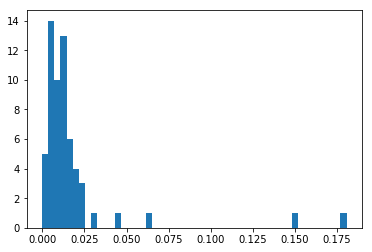

In [257]:
IC = np.array(shop_count)
IR = np.array(shop_corr)

A = plt.hist( IR[IC > 1 ], bins=50 )
midpoints = 0.5 * A[1][1:] + 0.5 * A[1][:-1]
print(np.dot( midpoints, A[0]) / A[0].sum())
print(np.median(shop_count))

0.035633210795295966
42.0


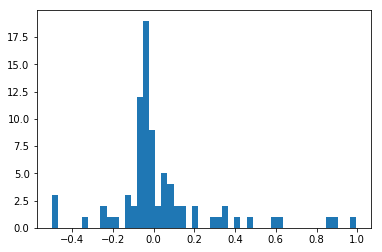

In [256]:
IC = np.array(cat_count)
IR = np.array(cat_corr)

A = plt.hist( IR[IC > 1 ], bins=50 )
midpoints = 0.5 * A[1][1:] + 0.5 * A[1][:-1]
print(np.dot( midpoints, A[0]) / A[0].sum())
print(np.median(cat_count))

0.00654267457781822
15.0


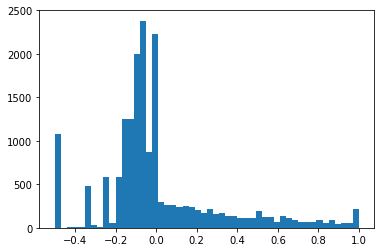

In [255]:
IC = np.array(item_count)
IR = np.array(item_corr)

A = plt.hist( IR[IC > 1 ], bins=50 )
midpoints = 0.5 * A[1][1:] + 0.5 * A[1][:-1]
print(np.dot( midpoints, A[0]) / A[0].sum())
print(np.median(item_count))

In [446]:
n_clusters = 20
eval_lags = [ 1, 2, 3, 6, 9, 12 ]

eval_lags = [ 1, 2, 3, 6, 9, 12 ]
train_rows = sorted( -np.array(eval_lags) - 1 )
valid_rows = -1
all_rows = train_rows + [valid_rows]
ts_full = kg.ts['sales'].iloc[all_rows].to_numpy()
ts_train = kg.ts['sales'].iloc[:-1].to_numpy()

mu = np.nanmean( ts_train, axis=0 )
sigma = np.nanstd( ts_train, axis=0 )

# Don't divide by zero for constant series
sigma[sigma==0] = 1
ts_norm = ( ts_full - mu ) / sigma

# Fit the model
model = KMeans( n_clusters=n_clusters )
model.fit( ts_norm[:-1,:].T )

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=20, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

(array([100063.,   7715.,   9698.,  12064.,  12095., 229567.,  25138.,
          7595.,  14131.,   6058.]),
 array([ 0. ,  1.9,  3.8,  5.7,  7.6,  9.5, 11.4, 13.3, 15.2, 17.1, 19. ]),
 <a list of 10 Patch objects>)

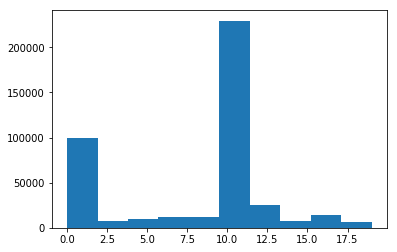

In [447]:
plt.hist( model.labels_ )

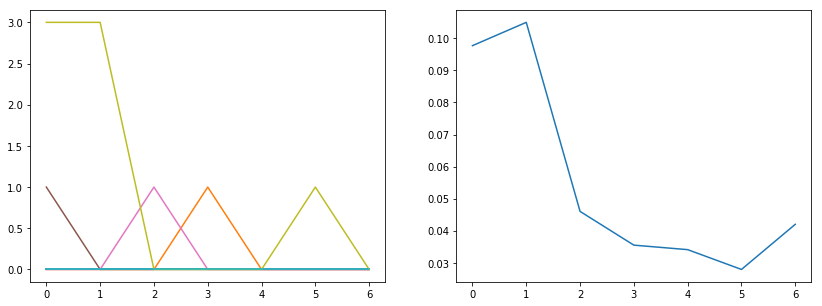

In [448]:
tmp = ts_full[:,model.labels_ == 0 ]

fig = plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot( tmp[:,:20] )
plt.subplot(1,2,2)
plt.plot( np.mean( tmp, axis=1 ) )

In [454]:
def box_plot( model, ts_norm, col ):
    f = ts_norm[:,model.labels_ == col ].T
    mins = f.min(axis=0)
    maxes = f.max(axis=0)
    means = f.mean(axis=0)
    q_low = np.quantile(f, 0.01, axis=0 )
    q_high = np.quantile(f, 0.99, axis=0 )
    std = f.std(axis=0)

    # create stacked errorbars:
    L = ts_norm.shape[0]
    plt.errorbar(np.arange(L), means, [means - mins, maxes - means],
                 fmt='.k', ecolor='red', lw=1)
    plt.errorbar(np.arange(L), means, [means - q_low, q_high - means],
                 fmt='.k', ecolor='blue', lw=6)
    plt.errorbar(np.arange(L), means, std, fmt='ok', lw=20)


(-10, 10)

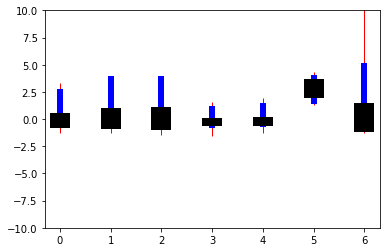

In [483]:
box_plot( model, ts_norm, col=19 )
plt.ylim(-10,10)

In [17]:
def unnormalize( y_norm, mu, sigma ):
    
    y = y_norm * sigma + mu
    return(y)

def normalize( y, mu, sigma ):
    
    y_norm = ( y - mu ) / sigma
    return(y_norm)

In [25]:
from sklearn.neighbors import KNeighborsRegressor

n_neighbors = 5
metric = 'distance'  # Must be one of 'uniform' or 'distance'
eval_lags = [ 1, 2, 3, 6, 9, 12 ]

train_rows = sorted( -np.array(eval_lags) - 1 )
test_rows = sorted( -np.array(eval_lags) )
valid_rows = -1
all_rows = train_rows + [valid_rows]

ts_full = kg.ts['sales'].iloc[all_rows].to_numpy()
ts_train = ts_full[:-1]
y_train = ts_full[-1]

ts_test = kg.ts['sales'].iloc[test_rows].to_numpy()

mu = np.nanmean( ts_train, axis=0 )
sigma = np.nanstd( ts_train, axis=0 )

# Don't divide by zero for constant series
sigma[sigma==0] = 1
ts_full_norm = normalize( ts_full, mu, sigma )
ts_train_norm = normalize( ts_train, mu, sigma )
ts_test_norm = normalize( ts_test, mu, sigma )

y_train_norm = ts_full_norm[-1]

# Fit the model
model = KNeighborsRegressor(n_neighbors=n_neighbors, weights=metric )
model.fit( ts_train_norm.T, y_train_norm )


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='distance')

In [26]:
yhat_train_norm = model.predict( ts_train_norm.T )

In [29]:
yhat_train = unnormalize( yhat_train_norm, mu, sigma )
rmse( yhat_train, y_train )

1.2944200798178103

In [31]:
yhat_test_norm = model.predict( ts_test_norm.T )

In [59]:

yhat_test = unnormalize( yhat_test_norm, mu, sigma )
yhat_test = np.maximum( yhat_test, 0 )
yhat_test = np.minimum( yhat_test, 20 )

# Format the forecast as a Pandas Series and write the output to .csv
fcst = pd.Series( yhat_test.ravel(), index=pd.Index( kg.ts['sales'].columns ) )
output = format_forecast( kg.csv['test'], fcst )

output.to_csv( '../forecasts/knn_02.csv', index=False, header=True )

In [54]:
# Format the forecast as a Pandas Series and write the output to .csv
y_prev = pd.Series( ts_test[-1].ravel(), index=pd.Index( kg.ts['sales'].columns ) )
previous_values = format_forecast( kg.csv['test'], y_prev )

In [80]:
from sklearn.cluster import KMeans

n_clusters = 20
eval_lags = [ 1, 2, 3, 6, 9, 12 ]

train_rows = sorted( -np.array(eval_lags) - 1 )
test_rows = sorted( -np.array(eval_lags) )
valid_rows = -1
all_rows = train_rows + [valid_rows]

x_full = kg.ts['sales'].iloc[all_rows].to_numpy()
x_train = x_full[:-1]
y_train = x_full[-1]

x_test = kg.ts['sales'].iloc[test_rows].to_numpy()

mu = np.nanmean( x_train, axis=0 )
sigma = np.nanstd( x_train, axis=0 )

# Don't divide by zero for constant series
sigma[sigma==0] = 1
x_full_norm = normalize( x_full, mu, sigma )
x_train_norm = normalize( x_train, mu, sigma )
x_test_norm = normalize( x_test, mu, sigma )

y_train_norm = x_full_norm[-1]

# Fit the model
model = KMeans( n_clusters=n_clusters )
model.fit( x_train_norm.T )

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=20, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [89]:
test_labels = model.predict(x_test_norm.T)

In [90]:
test_labels_mean = [ np.mean( y_train_norm[ test_labels == p ]) for p in range(n_clusters) ]

In [96]:
yhat_test_norm = [ test_labels_mean[x] for x in test_labels ]

In [98]:
yhat_test = unnormalize( yhat_test_norm, mu, sigma )
yhat_test = np.maximum( yhat_test, 0 )
yhat_test = np.minimum( yhat_test, 20 )

# Format the forecast as a Pandas Series and write the output to .csv
fcst = pd.Series( yhat_test.ravel(), index=pd.Index( kg.ts['sales'].columns ) )
output = format_forecast( kg.csv['test'], fcst )

output.to_csv( '../forecasts/kmeans_01.csv', index=False, header=True )


In [184]:
import importlib
import kaggle_forecast 
importlib.reload( kaggle_forecast )

from kaggle_forecast import *

NameError: name 'kg' is not defined

NameError: name 'kmr' is not defined

array([0.        , 0.        , 0.07545486, ..., 0.        , 0.        ,
       0.        ])

In [2]:
kmr

NameError: name 'kmr' is not defined

In [41]:
data_type = TRAIN
date_nums = kmr.xx[data_type][:,idx_db_col]

idx = [ r > kmr.date_block_cutoff for r in date_nums ]


0

In [59]:
kmr.xx[TRAIN].sum?

In [197]:

# Get the existing data sets
date_nums = self.xx[data_type][:,idx_db_col]
xx_input = np.hstack( [ self.xx[data_type][:,:idx_db_col], \
                        self.xx[data_type][:,idx_db_col+1:] ] )
yy_input = self.yy[data_type].copy()

# Exclude date blocks before the cutoff
if date_block_cutoff > 0:
    # Find the rows that are greater than thte lower date cutoff
    idx = [ r > self.date_block_cutoff for r in date_nums ]
    xx_output = xx_input[idx,:]
    yy_output = xx_input[idx,:]
else:
    # No need to make copies if we are not removing rows
    xx_output = xx_input
    yy_output = yy_input     

In [ ]:
np.all( xx[VALID][:,0] == yy[TRAIN] )